# Exercises and examples done in class on 3 April 2025

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

plt.rcParams["figure.figsize"] = (12,3)

In [4]:
# utility function to plot the magnitude spctrum (or the periodogram)
def spectrum(x, f=2*np.pi, pos_only=False, periodogram=False):
    N = len(x)
    ix = np.arange(0, int(N/2 + 1)) 
    if not pos_only:
        ix = np.r_[ np.arange(int(N/2 + 0.5), N), ix ].astype(int)
    X = np.abs(np.fft.fft(x)[ix])
    if periodogram:
        X = (X ** 2) / N
    ix[:N//2] -= 0 if pos_only else N
    return f * ix / N, X 

# Signal models in the time domain

### Exercise: deterministic signals  
Generate a discrete-time deterministic signal containing the mix of 3 musical notes, a G3 a B3 and a D4.
Assume the signal is the result of sampling a 4-second long continuous-time signal at fs = 44000 samples per second. Plot the
signal and play it.

In [7]:
Fs = 44100
T = 4
# frequencies of the three notes
G3, B3, D4 = [196, 247, 293.7] 

In [11]:
# digital frequency: w_i = 2pi (f_i/Fs)
notes = 2 * np.pi / Fs * np.array([G3, B3, D4])

# compact way to generate the sum of the three sinusoids x[n] = sum_i cos(w_i * n), n = 0, 1, ..., N-1
#   1) number of samples N = Fs * T
#   2) build a 3 x N matrix A where A[i, n] = w_i * n
#   3) compute C = cos(A), so C[i, n] = cos(2pi f_i/Fs * n)
#   4) sum the columns of C to obtain x
x = np.sum(np.cos(np.outer(notes, np.arange(T * Fs))), axis=0)

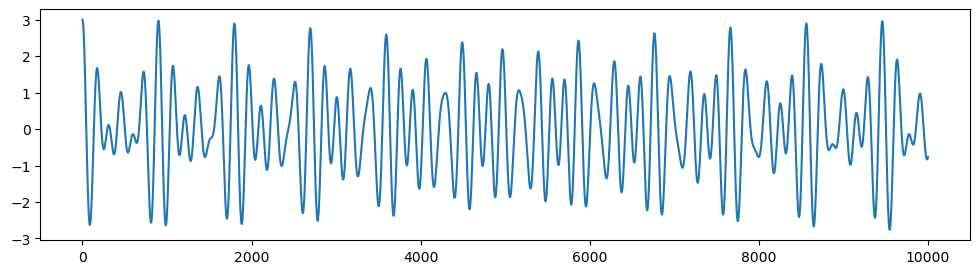

In [13]:
plt.plot(x[:10000]);

In [14]:
Audio(x, rate=Fs)

### Exercise: random signals (noise)  
 * Generate 150,000 white noise samples using a zero-mean, unit-variance Gaussian random number generator. Plot the data and play it as an audio signal assuming a sampling rate of $44,100$ samples per second.
 *  Generate 150,000 white noise samples using a unifor random number generator between $-1$ and $1$. Plot the data and play it as an audio signal assuming a sampling rate of $44,100$ samples per second.
 * Can you tell the difference between the two types of white noise, either from the plots and/or from the sounds?

In [18]:
N = 150000

wgn = np.random.randn(N)
wun = (np.random.rand(N) - 0.5) * 2

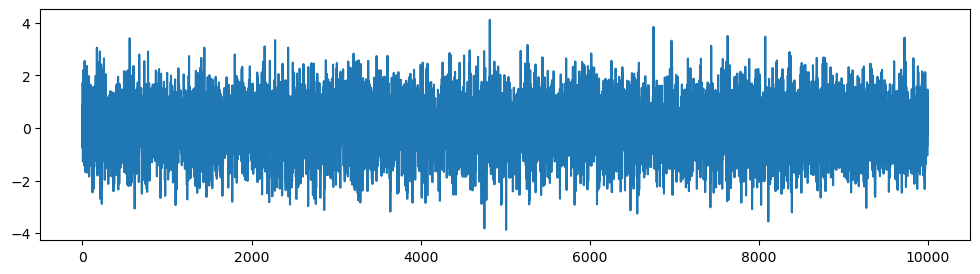

In [20]:
plt.plot(wgn[:10000]);

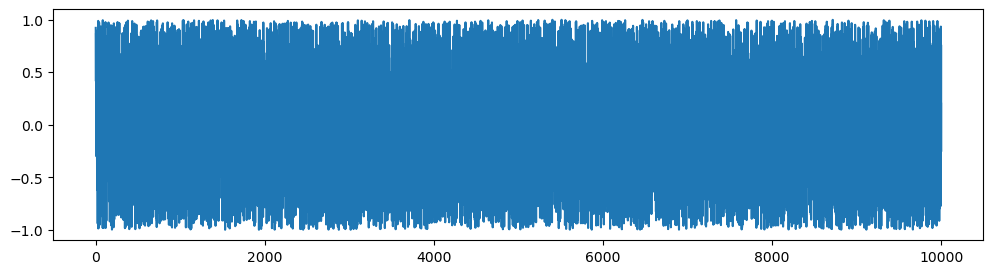

In [21]:
plt.plot(wun[:10000]);

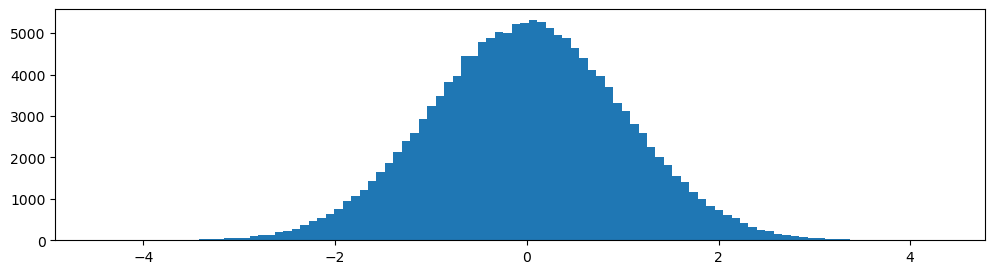

In [24]:
plt.hist(wgn, bins=100);

To avoid the automatic amplitude normalization performed by IPython.Audio, let's normalize the signals by the same value. We use $3\sigma$ (where $\sigma$ is the standard deviation of the Gaussian noise) and clip Gaussian samples larger than that in magnitude. This will help us compare the sound of each noise more fairly

In [27]:
def norm_clip(x, V):
    y = x / V
    y[y > 1] = 1
    y[y < -1] = -1
    return y

In [29]:
max_amplitude = 3

Audio(norm_clip(wgn, max_amplitude), rate=Fs, normalize=False)

In [31]:
Audio(norm_clip(wun, max_amplitude), rate=Fs, normalize=False)

### Exercise: empirical statistics  

For the noise signals generated before, let's compare the empirical estimate of the mean and the variance to their empirical estimations: remember that
 * mean of both white noise signals should be zero
 * variance should be 1 for the Gaussian noise and $(B-A)^2/12$ for uniformly-distributed over the interval $[A, B]$ (in our case 1/3 since the interva is $[-1, 1]$) 

To see the effects of sample data size:
 * Compute mean and variance using only 100 generated samples;
 *  Compute mean and variance using all of the generated samples;

In [34]:
def mean_var(x, N):
    N = min(len(x), N)
    m = np.mean(x[:N])
    v = np.mean((x[:N] - m) ** 2)
    return m, v

In [36]:
for N in [100, 1000, 100000]:
    print(N, mean_var(wgn, N), mean_var(wun, N))

100 (0.15229094717946573, 0.9080010978586556) (0.0278271800770296, 0.35490296449741093)
1000 (0.027627212398135904, 0.9934972982229606) (0.013913354092622532, 0.3383676684609774)
100000 (-0.0012680482719087936, 1.001545733396538) (0.0013389958451780692, 0.3335984518937791)


# Signal analysis in the frequency domain

## Autocorrelation

In [40]:
def autocorrelation(x, biased=True, positive_lags_only=False):
    N = len(x)
    k = np.arange(-N+1, N)   # range for the lag index k
    # normalization factor is 1/N for biased, 1/(N-|k|) for unbiased
    a = N * np.ones(2 * N - 1) - (0 if biased else np.abs(k))
    r = np.correlate(x, x, 'full') / a
    if positive_lags_only:
        return k[-N:], r[-N:]
    else:
        return k, r

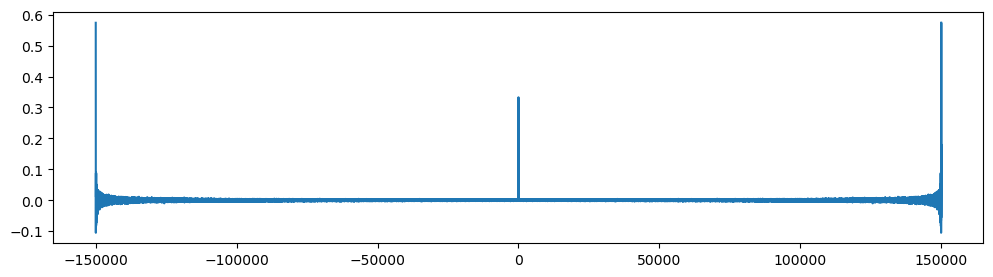

In [42]:
# unbiased correlation
plt.plot(*autocorrelation(wun, biased=False));

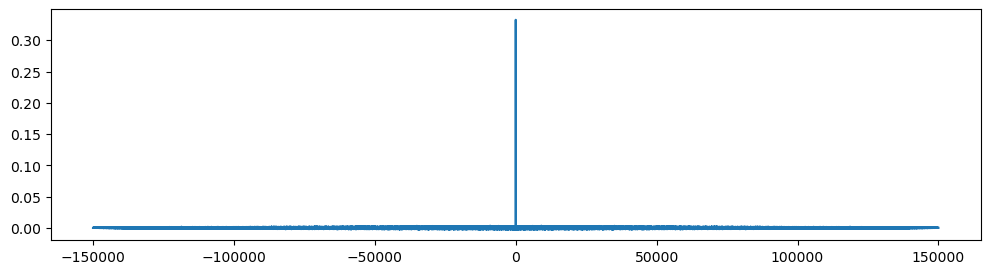

In [43]:
# biased correlation
plt.plot(*autocorrelation(wun, biased=True));

## Properties of the autocorrelation

The autocorrelation of a signal preserves the properties of the original signal. Here we plot a few test signals and their autocorrelation

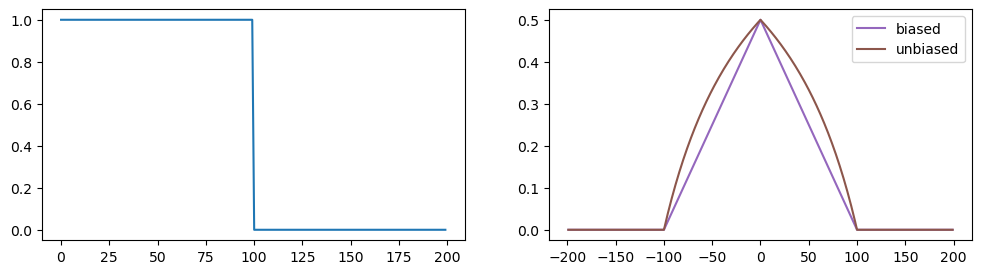

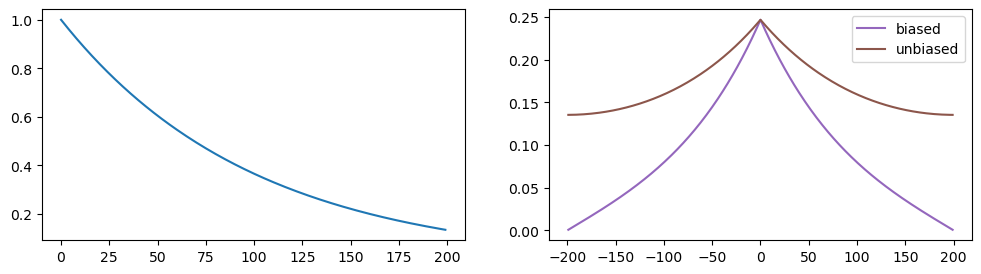

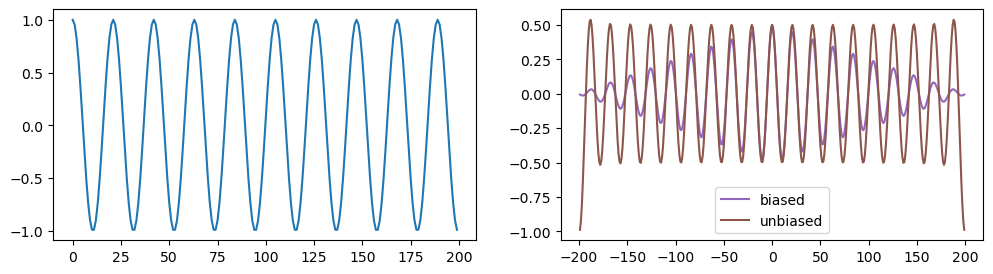

In [45]:
N = 200

signals = (
    np.r_[np.ones(100), np.zeros(N-100)],  # rectangular signal
    0.99 ** np.arange(0, N),               # decaying exponential
    np.cos(2 * np.pi / 21 * np.arange(N))  # sinusoid
)

for x in signals:
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(x)
    plt.subplot(1,2,2)
    plt.plot(*autocorrelation(x, biased=True), 'C4', label='biased');
    plt.plot(*autocorrelation(x, biased=False), 'C5', label='unbiased');
    plt.legend();

The autocorrelation is robust with respect to independent, additive noise

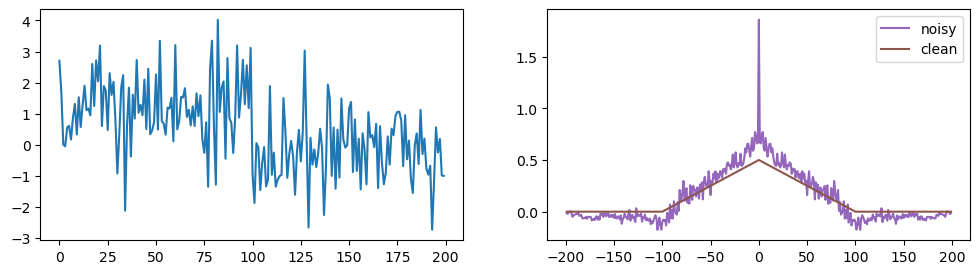

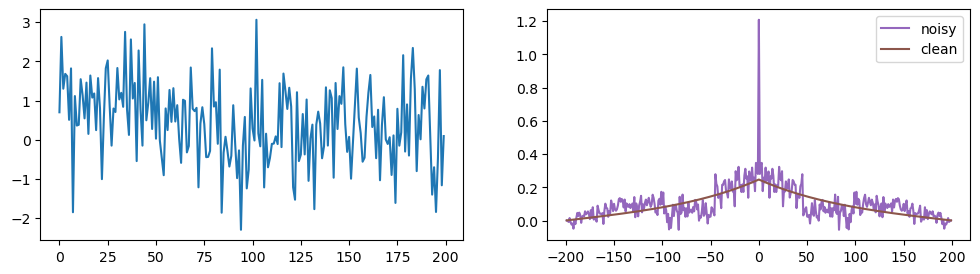

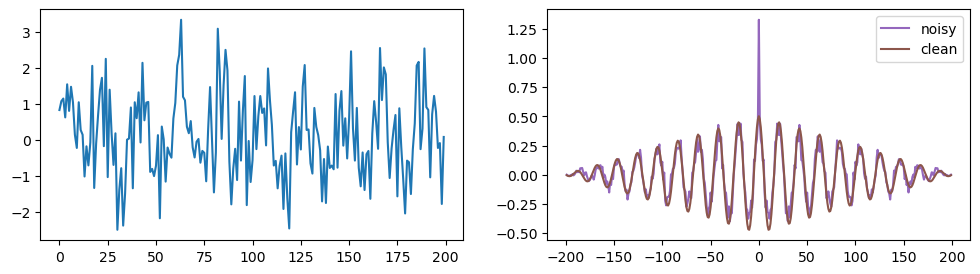

In [47]:
for x in signals:
    y = x + np.random.randn(len(x)) * np.max(np.abs(x)) 
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(y)
    plt.subplot(1,2,2)
    plt.plot(*autocorrelation(y, biased=True), 'C4', label='noisy');
    plt.plot(*autocorrelation(x, biased=True), 'C5', label='clean');
    plt.legend();

# Periodogram

Let $x[n]$ be a length-$N$ signal; call $X[k]$ its $N$ DFT coefficients ($0 \le k \le N-1$) and $r_x[m]$ its $2N-1$ biased autocorrelation ($-N+1 \le m \le N-1$).

Periodogram definition 1:
$$
    P_x[k] = |X[k]|^2/N
$$

Periodogram definition 2:
Call $R[k]$ the DFT of the $N$ autocorrelation values $r[0], r[1], \ldots, r[N-1]$
$$
    P_x[k] = 2\text{Re}\{R[k]\} - r[0]
$$

In [ ]:
# Let's verify that the two definitions coincide

for x in signals:

    N = len(x)
    _, r = autocorrelation(x, biased=True, positive_lags_only=True)
    
    P_1 = (np.abs(np.fft.fft(x)) ** 2) / N
    P_2 = 2 * np.real(np.fft.fft(r)) - r[0]
    
    plt.figure()    
    plt.plot(P_1[:N//2], label='definition 1');
    plt.plot(P_2[:N//2], label='definition 2');
    plt.legend();

### Exercise: peroiodogram resolution

Consider a sampling frequency of $f_s=5KHz$ and generate the following signals:

  * A signal $x_1[n]$ obtained by sampling $T=2$ seconds of a sinusoid with frequency $f_1=440Hz$;
  * A signal $x_1[n]$ obtained by sampling $T=2$ seconds of a sinusoid with frequency $f_2=490Hz$;
  * The sum of the above signals $x[n]=x_1[n]+x_2[n]$;  
  * A white noise signal $w_1[n]$, with the same number of samples as $x[n]$ and Gaussian distribution with unit variance
  * The signal $y[n]=x[n]+w[n]$.

With these signals:
  * Compute the periodogram $P_{xx}^N$ of $x$, using all the available samples;
  * Compute the periodogram $P_{xx}^{100}$of $x$, using only 100 samples ;
  * Compute the periodogram $P_{xx}^{40}$of $x$, using only 40 samples;
  * Plot each result,labeling the frequency axis in Hz.

What can you observe? Compute the resolution of the periodogram. Repeat the exercise for the signal $y$.


In [ ]:
fs = 5000
T = 2
f1, f2 = 440, 490

In [ ]:
N = int(T * fs)
x1 = np.sin(2 * np.pi * f1 / fs * np.arange(N))
x2 = np.sin(2 * np.pi * f2 / fs * np.arange(N))
x = x1 + x2
wgn = np.random.randn(N)
y = x + wgn

In [ ]:
for n, M in enumerate([N, 110, 40]):
    plt.subplot(1, 3, n+1)
    plt.plot(*spectrum(x[:M], periodogram=True, f=fs, pos_only=True))

In [ ]:
for n, M in enumerate([N, 110, 40]):
    plt.subplot(1, 3, n+1)
    plt.plot(*spectrum(y[:M], periodogram=True, f=fs, pos_only=True))

In [ ]:
for x in signals:
    y = x + np.random.randn(len(x)) * np.max(np.abs(x)) 
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(y)
    plt.subplot(1,2,2)
    plt.plot(*spectrum(y, periodogram=False, f=fs, pos_only=True), 'C4', label='noisy');
    plt.plot(*spectrum(y, periodogram=True, f=fs, pos_only=True), 'C6', label='noisy');
    plt.plot(*spectrum(x, periodogram=False, f=fs, pos_only=True), 'C5', label='clean');
    #plt.plot(*autocorrelation(x, biased=True), 'C5', label='clean');
    plt.legend();